### Resultados con geometrías complejas y FEM Source

In [1]:
import os
os.chdir('..')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from room.geometry_generator import calculation_of_geometry
from mesh.mesh_3D_complex import create_complex_mesh
from FEM.FEM_source import FEM_Source_Solver_Average
from aux.merit_figure import merit_magnitude_deviation, merit_spatial_deviation
from plots.graph_room_outline import plot_room_outline

/home/diber/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
Lx = 250       # Largo de la sala en X 
Ly = 300       # Largo de la sala en Y
Lz = 220       # Alto de la sala
Dx = 50        # Delta X
Dy = 80        # Delta Y
Dz = 10        # Delta Z

# Posiciones fuente y receptor (en metros)
source_position = (1.9, 1.0, 1.3)
receptor_position = (1.25, 1.9, 1.2)

# Parametros de control
N = 250        # Densidad de la grilla del generador de geometrías
M = 200       # Cantidad de salas a generar
n_walls = 2    # Número de cortes en las paredes
res_freq = 2

# Almacenar toda la data
rooms = calculation_of_geometry(Lx, Ly, Dx, Dy, N, M, n_walls)
mesh = "room_mesh_complex"  # Crear malla con el script correspondiente
mesh1 = "room_mesh_complex1"  # Crear malla con el script correspondiente
mesh2 = "room_mesh_complex2"  # Crear malla con el script correspondiente
mesh3 = "room_mesh_complex3"  # Crear malla con el script correspondiente

# Freqs maxima en la grilla adaptativa
f1_max = 80
f2_max = 140
f3_max = 200

# Guardar los resultados 
mag_responses = []
merit_sv_values = []
merit_md_values = []

In [4]:
# Itera y almacena los valores para encontrar el mejor cuarto
for i in range(M):
    print("Vamos por el room: ", i)

    # Crea la malla de la geometría selecionada
    Z = (Lz - np.random.uniform(0, Dz))/100
    create_complex_mesh(rooms[i], Z, source_position, 80, mesh1)
    create_complex_mesh(rooms[i], Z, source_position, 140, mesh2)
    create_complex_mesh(rooms[i], Z, source_position, 200, mesh3)

    # Evalua la rta en frecuencia para esa sala
    f1 = np.arange(20, 80, res_freq)
    res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

    f2 = np.arange(80, 140, res_freq)
    res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

    f3 = np.arange(140, 200, res_freq)
    res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

    res_tot = np.hstack([res1, res2, res3])
    res_tot_prom = np.sum(res_tot, axis=0) / 7

    # Calcula figuras de mérito
    sv_merit = merit_spatial_deviation(res_tot)
    md_merit = merit_magnitude_deviation(res_tot)
    
    merit_sv_values.append(sv_merit)
    merit_md_values.append(md_merit)
    mag_responses.append(res_tot_prom)

Vamos por el room:  0
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 639 nodes
Info    : 3514 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1537 nodes
Info    : 8617 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entities
Info    : 4744 nodes
Info    : 27895 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Vamos por el room:  1
Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 696 nodes
Info    : 3844 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1734 nodes
Info    : 9795 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entit

In [5]:
f_tot =  np.hstack([f1, f2, f3])
merit_sv_values = np.array(merit_sv_values)
merit_md_values = np.array(merit_md_values)
merit_general = merit_md_values + merit_sv_values

idx_best_room = np.argmin(merit_general)
idx_worst_room = np.argmax(merit_general)

print(f"El valor de mértio mínimo es: {merit_general[idx_best_room]} | Con SV: {merit_sv_values[idx_best_room]} | Con MD: {merit_md_values[idx_best_room]}" )
print("............................")
print(f"El peor valor de mérito es: {merit_general[idx_worst_room]} | Con SV: {merit_sv_values[idx_worst_room]} | Con MD: {merit_md_values[idx_worst_room]}" )
print("............................")
print("El valor de mértio promedio es: ", np.mean(merit_general))


El valor de mértio mínimo es: 12.912566395949979 | Con SV: 3.3828814055652288 | Con MD: 9.52968499038475
............................
El peor valor de mérito es: 20.965012418762733 | Con SV: 3.7747824008495474 | Con MD: 17.190230017913184
............................
El valor de mértio promedio es:  16.703129856014257


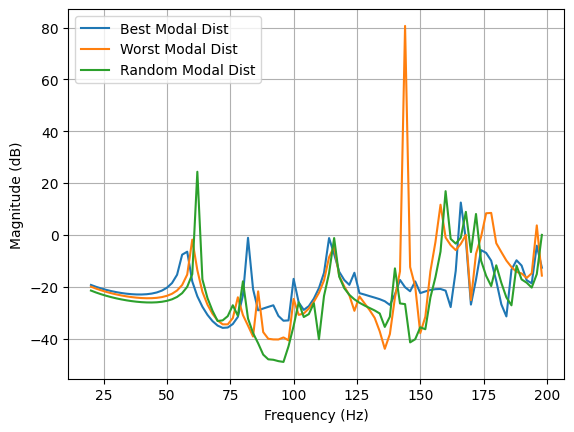

In [6]:
best_room_mag = mag_responses[idx_best_room]
worst_room_mag = mag_responses[idx_worst_room]
random_room_mag = mag_responses[np.random.randint(0, M - 1)]

plt.figure("Resultado magnitud")
plt.plot(f_tot, best_room_mag, label= "Best Modal Dist")
plt.plot(f_tot, worst_room_mag, label= "Worst Modal Dist")
plt.plot(f_tot, random_room_mag, label= "Random Modal Dist")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Para comparar las primeras 3 soluciones
merit_index = list(enumerate(merit_general))
merit_sorted = sorted(merit_index, key=lambda x: x[1])
index_merit_sored, merit_values = zip(*merit_sorted)

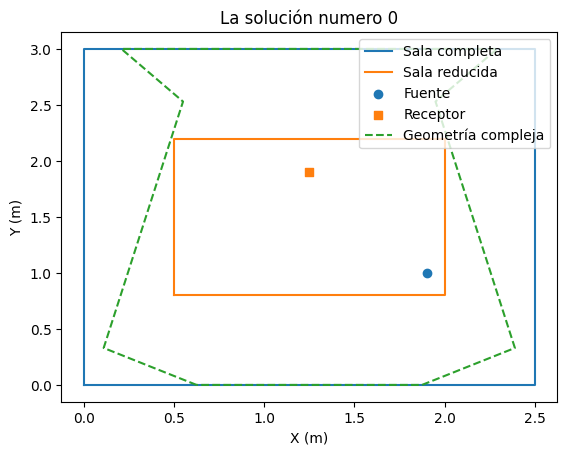

La figura de mérito de este cuarto es de:  12.912566395949979


In [19]:
solution = 0
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[index_merit_sored[solution]], f"La solución numero {solution}")
print("La figura de mérito de este cuarto es de: ", merit_general[index_merit_sored[solution]])

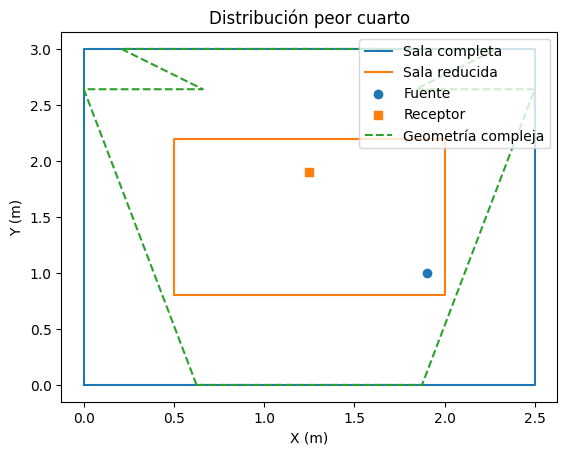

In [8]:
plot_room_outline(Lx, Ly, Dx, Dy, source_position, receptor_position, rooms[idx_worst_room], "Distribución peor cuarto")

Genero pequeños cambios a la primera geometría para analizar la mejora del MCD

In [20]:
rooms[idx_best_room]

array([[0.625     , 0.        ],
       [0.11      , 0.33      ],
       [0.55      , 2.53      ],
       [0.20833333, 3.        ],
       [2.29166667, 3.        ],
       [1.95      , 2.53      ],
       [2.39      , 0.33      ],
       [1.875     , 0.        ]])

In [21]:
room_optim1 =np.array([[0.625     , 0.        ],
                       [0.12      , 0.33      ],
                       [0.55      , 2.53      ],
                       [0.19      , 3.        ],
                       [2.31      , 3.        ],
                       [1.95      , 2.53      ],
                       [2.38      , 0.33      ],
                       [1.875     , 0.        ]])


create_complex_mesh(room_optim1, 2.2, source_position, 80, mesh1)
create_complex_mesh(room_optim1, 2.2, source_position, 140, mesh2)
create_complex_mesh(room_optim1, 2.2, source_position, 200, mesh3)

# Evalua la rta en frecuencia para esa sala
f1 = np.arange(20, 80, res_freq)
res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

f2 = np.arange(80, 140, res_freq)
res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

f3 = np.arange(140, 200, res_freq)
res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

res_tot = np.hstack([res1, res2, res3])
res_tot_prom = np.sum(res_tot, axis=0) / 7

# Calcula figuras de mérito
sv_merit = merit_spatial_deviation(res_tot)
md_merit = merit_magnitude_deviation(res_tot)

print(f"Mérito total: {sv_merit + md_merit} | MD: {md_merit} | SV: {sv_merit}")

Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 645 nodes
Info    : 3513 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1454 nodes
Info    : 8007 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entities
Info    : 4449 nodes
Info    : 25894 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Mérito total: 16.997989588584787 | MD: 12.891287272830763 | SV: 4.106702315754025


In [22]:
room_optim1 =np.array([[0.625     , 0.        ],
                       [0.12      , 0.33      ],
                       [0.55      , 2.53      ],
                       [0.19      , 3.        ],
                       [2.31      , 3.        ],
                       [1.95      , 2.53      ],
                       [2.38      , 0.33      ],
                       [1.875     , 0.        ]])


create_complex_mesh(room_optim1, 2.1, source_position, 80, mesh1)
create_complex_mesh(room_optim1, 2.1, source_position, 140, mesh2)
create_complex_mesh(room_optim1, 2.1, source_position, 200, mesh3)

# Evalua la rta en frecuencia para esa sala
f1 = np.arange(20, 80, res_freq)
res1 = FEM_Source_Solver_Average(f1, f'mallado/{mesh1}.msh', receptor_position)

f2 = np.arange(80, 140, res_freq)
res2 = FEM_Source_Solver_Average(f2, f'mallado/{mesh2}.msh', receptor_position)

f3 = np.arange(140, 200, res_freq)
res3 = FEM_Source_Solver_Average(f3, f'mallado/{mesh3}.msh', receptor_position)

res_tot = np.hstack([res1, res2, res3])
res_tot_prom = np.sum(res_tot, axis=0) / 7

# Calcula figuras de mérito
sv_merit = merit_spatial_deviation(res_tot)
md_merit = merit_magnitude_deviation(res_tot)

print(f"Mérito total: {sv_merit + md_merit} | MD: {md_merit} | SV: {sv_merit}")


Info    : Reading 'mallado/room_mesh_complex1.msh'...
Info    : 57 entities
Info    : 541 nodes
Info    : 2890 elements
Info    : Done reading 'mallado/room_mesh_complex1.msh'
Info    : Reading 'mallado/room_mesh_complex2.msh'...
Info    : 57 entities
Info    : 1401 nodes
Info    : 7674 elements
Info    : Done reading 'mallado/room_mesh_complex2.msh'
Info    : Reading 'mallado/room_mesh_complex3.msh'...
Info    : 57 entities
Info    : 4026 nodes
Info    : 23271 elements
Info    : Done reading 'mallado/room_mesh_complex3.msh'
Mérito total: 12.582928558855492 | MD: 9.386524373016039 | SV: 3.1964041858394534


Entre el ejemplo este y el de arriba solo cambia que la altura del techo es de 10 cm, es decir, con 10cm de diferencia en el techo de casi 4 dB de diferencia en el MCD.